# Introdução a Redes Neurais
## Atividade 03
#### Desenvolver modelos para um sistema de compressão de unidade estacionárias de produção de petróleo
##### Parte 02

Import das bibliotecas

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

### Modelo SARIMAX

Conjunto de dados de pressão de sucção contida no arquivo pressao_vazao_succao_c2.csv:

In [49]:
dataset = pd.read_csv('pressao_vazao_succao_c2.csv')
dataset.head(3)

,Data,Press,Vaz
0,2000-01-01,0.014555,0.014555
1,2000-01-02,0.245910,-0.502960
2,2000-01-03,0.555520,0.387150


In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40001 entries, 0 to 40000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    40001 non-null  object 
 1   Press   40001 non-null  float64
 2   Vaz     40001 non-null  float64
dtypes: float64(2), object(1)
memory usage: 937.6+ KB


Como todas as colunas não apresentam dados nulos ou ausentes, então a etapa de eliminação de valores nulos não será necessária.

In [51]:
# Criação de um conjunto de dados para a predição
steps=-1
dataset_for_prediction = dataset.copy()
dataset_for_prediction['Atual'] = dataset_for_prediction['Press'].shift(steps)
# Substituir o contador pelas respectivas datas
dataset_for_prediction['Data'] = pd.to_datetime(dataset_for_prediction['Data'])
dataset_for_prediction.index = dataset_for_prediction['Data']
dataset_for_prediction.head(-1)

,Data,Press,Vaz,Atual
Data,,,,
2000-01-01,2000-01-01,0.014555,0.014555,0.24591
2000-01-02,2000-01-02,0.245910,-0.502960,0.55552
2000-01-03,2000-01-03,0.555520,0.387150,0.01562
2000-01-04,2000-01-04,0.015620,-0.164310,0.28784
2000-01-05,2000-01-05,0.287840,-0.421040,0.49252
...,...,...,...,...
2109-07-03,2109-07-03,15223.000000,-0.022208,15251.00000
2109-07-04,2109-07-04,15251.000000,-0.017206,15226.00000
2109-07-05,2109-07-05,15226.000000,-0.019092,15238.00000


Gráfico da variável objetivo da predição

Text(0.5, 1.0, 'Comportamento da pressão de sucção')

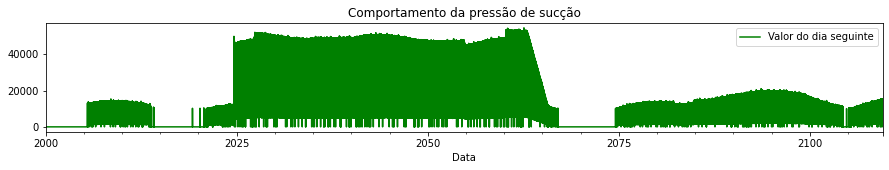

In [52]:
dataset_for_prediction['Press'].plot(figsize=(15,2), color='green')
plt.legend(['Valor do dia seguinte', 'Press'])
plt.title('Comportamento da pressão de sucção')

Gráfico da variável exógena

Text(0.5, 1.0, 'Comportamento da vazão de sucção')

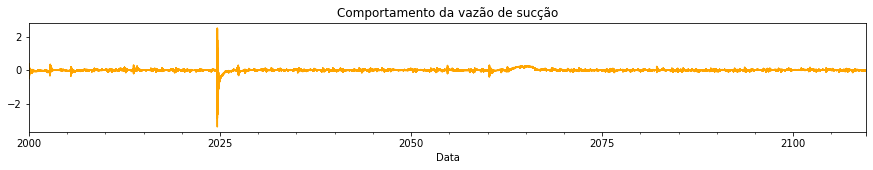

In [53]:
dataset_for_prediction['Vaz'].plot(figsize=(15,2), color='orange')
plt.title('Comportamento da vazão de sucção')

Normalização dos dados:

In [54]:
from sklearn.preprocessing import MinMaxScaler
# Das variáveis de entrada
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Press', 'Vaz']])
scaled_input = pd.DataFrame(scaled_input)
X = scaled_input
# Da variável de saída
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Atual']])
scaler_output =pd.DataFrame(scaler_output)
y = scaler_output

In [55]:
X.rename(columns={0:'Press', 1:'Vaz'}, inplace=True)
X.head(2)

,Press,Vaz
0,0.000000,0.576252
1,0.000004,0.488881


In [56]:
y.rename(columns={0:'Pressão de sucção do dia seguinte'}, inplace= True)
y.head(2)

,Pressão de sucção do dia seguinte
0,0.000004
1,0.000010


Separar dados de treinamento e teste

In [ ]:
train_size = int(len(dataset)*0.66)
test_size = int(len(dataset)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()
len(train_X)

26400

Decomposição da série

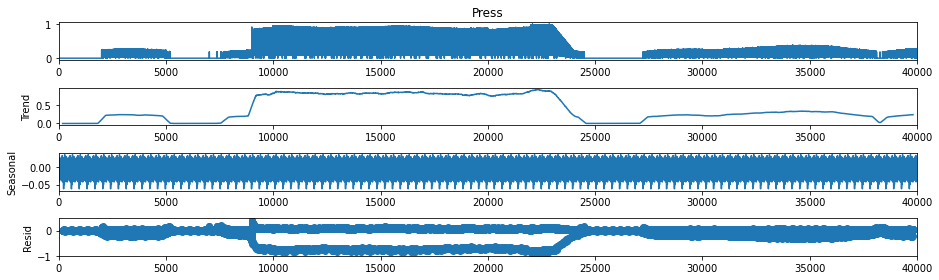

In [58]:
import statsmodels.api as sm
seas_d = sm.tsa.seasonal_decompose(X['Press'], model='add', period=365)
fig = seas_d.plot()
fig.set_size_inches((15, 10))
fig.set_figheight(4)
plt.show()

É possível observar que os dados não possuem tendência, porém apresenta sazonalidade com mesma frequência e amplitude constantes. Na parte residual nenhuma destas caracteristiacs foram observadas. Indicando caracterisica de aleatoriedade, ou seja, ruído branco.

Teste Dickey-Fuller Aumentado (ADF)

In [59]:
y_test = y['Pressão de sucção do dia seguinte'][:train_size].dropna()
dfout = {}
dftest = sm.tsa.adfuller(y_test.dropna(), autolag='AIC', regression='ct')
for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", " Stock Price")
else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", " Stock Price")

Strong evidence for  Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for  Stock Price


In [60]:
dfout={}
dftest=sm.tsa.adfuller(y_test.diff().dropna(), autolag='AIC', regression='ct')
for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", " Stock Price")
else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", " Stock Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary  Stock Price


Construção do modelo

C:\Users\camil\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


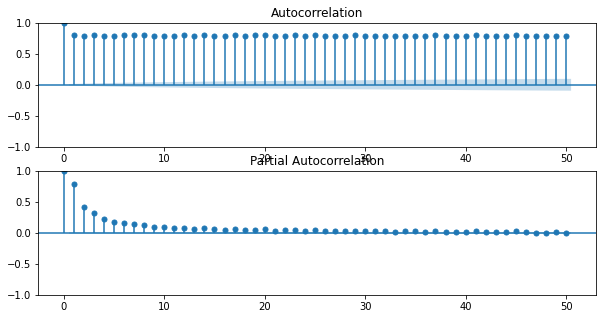

In [61]:
# Análise do modelo
fig,ax = plt.subplots(2,1, figsize=(10,5))
fig = sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig = sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [62]:
# Determinação da melhor configuração para o modelo
from pmdarima.arima import auto_arima

step_wise = auto_arima(train_y, 
 exogenous=train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14086.033, Time=61.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3684.896, Time=7.72 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4968.196, Time=18.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14083.011, Time=33.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3686.896, Time=19.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14087.450, Time=68.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8634.379, Time=32.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-14085.493, Time=82.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14045.653, Time=53.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14043.329, Time=69.58 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9174.541, Time=45.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-13901.323, Time=69.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-14122.272, Time=47.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14103.756, Time=32.15 s

In [63]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                26400
Model:               SARIMAX(3, 1, 1)   Log Likelihood                7068.586
Date:                Sat, 15 Jan 2022   AIC                         -14123.172
Time:                        21:42:18   BIC                         -14065.904
Sample:                             0   HQIC                        -14104.684
                              - 26400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Press          0.2766      0.048      5.715      0.000       0.182       0.371
Vaz           -0.9139      0.076    -12.058      0.000      -1.062      -0.765
ar.L1         -0.2664      0.048     -5.512      0.000      -0.361      -0.172
ar.L2         -0.0919      0.026     -3.512      0.000      -0.143      -0.041
ar.L3         -0.0180      0.012     -1.566      0.117      -0.041       0.005
ma.L1         -0.9794      0.001   -809.119      0.000      -0.982      -0.977
sigma2         0.0343      0.000    288.900      0.000       0.034       0.035
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            180624.12
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              16.58   Skew:                            -3.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Treinamento do modelo

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_y, 
 exog=train_X, 
 order=(3,1,1), 
 enforce_invertibility=False, 
 enforce_stationarity=False)

In [65]:
# Ajustes do modelo
results = model.fit()
results

C:\Users\camil\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predição dos resultados

In [73]:
predictions = results.predict(start=train_size, end=train_size+test_size+steps-1, exog=test_X[:-1])
predictions

26400    0.011114
26401    0.010635
26402   -0.004593
26403    0.013729
26404    0.008011
           ...   
39995    0.080285
39996    0.079642
39997    0.079815
39998    0.080268
39999    0.079645
Name: predicted_mean, Length: 13600, dtype: float64

In [74]:
forecast_1 = results.forecast(steps=test_size-1, exog=test_X[:-1])
forecast_1

26400    0.011114
26401    0.010635
26402   -0.004593
26403    0.013729
26404    0.008011
           ...   
39995    0.080285
39996    0.079642
39997    0.079815
39998    0.080268
39999    0.079645
Name: predicted_mean, Length: 13600, dtype: float64

In [76]:
act = pd.DataFrame(scaler_output.iloc[train_size:-1, 0])
act

,Pressão de sucção do dia seguinte
26400,0.000015
26401,0.000015
26402,0.000014
26403,0.000015
26404,0.000015
...,...
39995,0.280375
39996,0.279915
39997,0.280136
39998,0.280504


In [78]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_X[:-1].index
predictions

,predicted_mean
26400,0.011114
26401,0.010635
26402,-0.004593
26403,0.013729
26404,0.008011
...,...
39995,0.080285
39996,0.079642
39997,0.079815
39998,0.080268


In [79]:
predictions['Atual'] = act['Pressão de sucção do dia seguinte']
predictions.rename(columns={0:'Pred'}, inplace=True)
predictions

,predicted_mean,Atual
26400,0.011114,0.000015
26401,0.010635,0.000015
26402,-0.004593,0.000014
26403,0.013729,0.000015
26404,0.008011,0.000015
...,...,...
39995,0.080285,0.280375
39996,0.079642,0.279915
39997,0.079815,0.280136
39998,0.080268,0.280504


Avaliação das predições

In [80]:
from keras.metrics import MeanSquaredError
m = MeanSquaredError()
m.update_state(np.array(predictions['Atual']),np.array(predictions['predicted_mean']))
print('Teste RMSE modelo SARIMAX: %.3f' % m.result().numpy())

Teste RMSE modelo SARIMAX: 0.037


Gráfico dos resultados

Text(0.5, 1.0, 'MODELO SARIMAX')

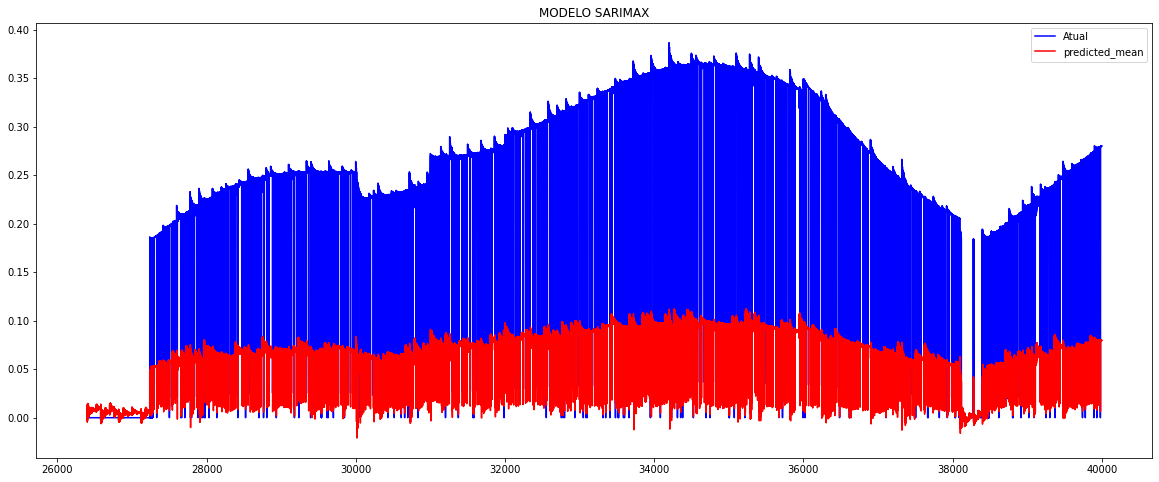

In [81]:
predictions['Atual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['predicted_mean'].plot(figsize=(20,8), legend=True, color='red')
plt.title('MODELO SARIMAX')